<a href="https://colab.research.google.com/github/sgangavaram/FMML2023/blob/MODULE-2/Module2_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 3: Manifold Learning Methods


## ISOMAP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

In [2]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)

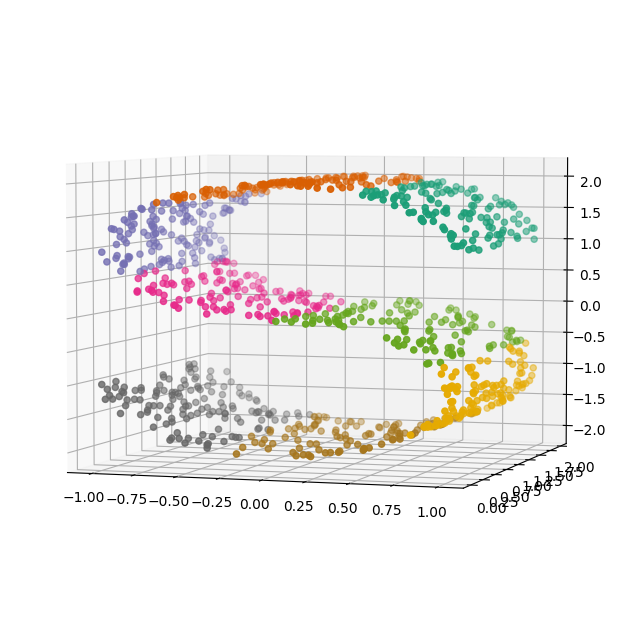

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

### Step 1a: First lets compute the distance matrix (pairwise Euclidean distances) from the data


In [4]:
def dist(a, b):
  return np.sqrt(sum((a - b) ** 2))
distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])
print(distances.shape)

(1000, 1000)


### Step 1b: Let us keep only k nearest neighbors for each point in the distance matrix.

In [5]:
n_neighbors = 10
neighbors = np.zeros(distances.shape)
sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

In [ ]:
neighbors.shape

(1000, 1000)



---

### Step 2: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.

In [6]:
from scipy.sparse.csgraph import shortest_path
graph = shortest_path(neighbors, directed=False)



---
### Step 3: Take the top d eigenvectors of the Gram matrix.


In [7]:
gram = (graph ** 2)

In [8]:
n_samples = gram.shape[0]
meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]
meanall = meanrows.sum() / n_samples
gram -= meanrows
gram -= meancols
gram += meanall

In [9]:
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T



---

## Plotting the resultant reduced_matrix


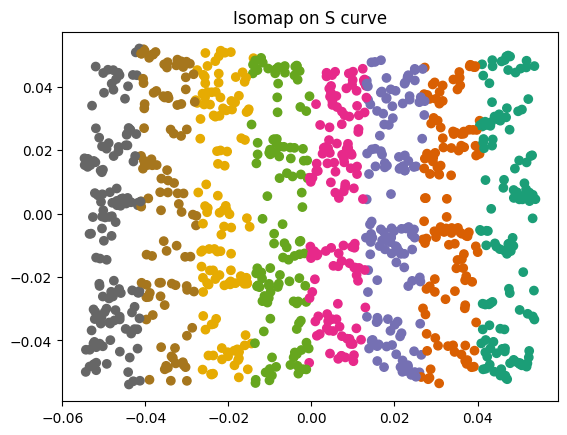

In [11]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('on')
plt.show()

In [12]:
from sklearn.manifold import Isomap

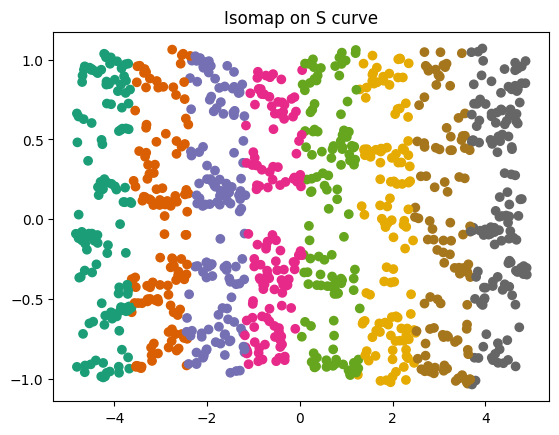

In [14]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('on')
plt.show()

In [15]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

(766, 2914)

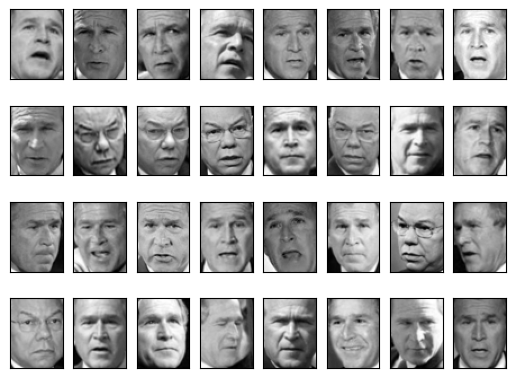

In [16]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

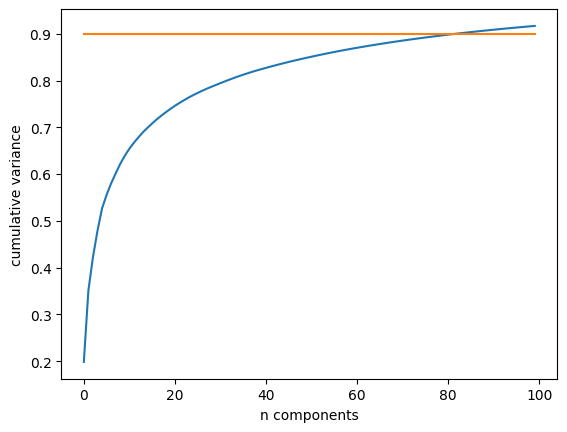

In [17]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

In [21]:
model = Isomap(n_components=2, n_neighbors = 4)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

In [22]:
from matplotlib import offsetbox
def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

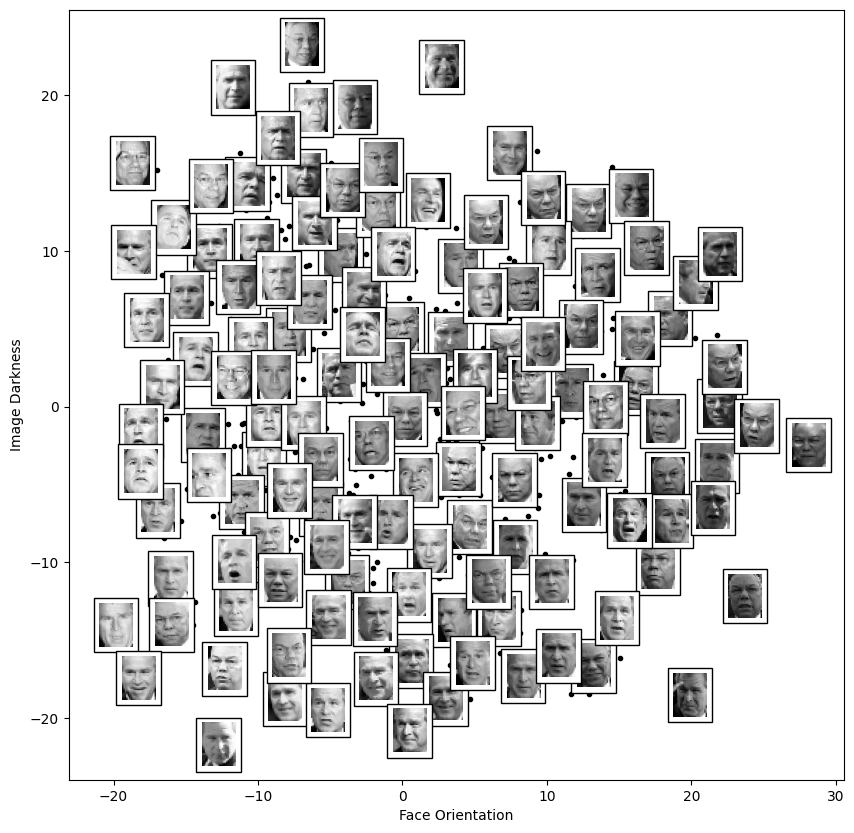

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 4),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")



---


## Questions

**How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?**

The number of neighbors considered in the Isomap algorithm has a significant impact on the quality of the output. When the number of neighbors is very large, the algorithm may become computationally expensive and may lead to overfitting. On the other hand, when the number of neighbors is very low, the algorithm may not be able to capture the underlying structure of the data and may lead to underfitting.

The number of neighbors should be chosen carefully to ensure that the algorithm is able to capture the underlying structure of the data without overfitting or underfitting.

**When is the ISOMAP algorithm superior to PCA?**

The ISOMAP algorithm is used for nonlinear dimensionality reduction when the underlying data has a complex and nonlinear structure. In contrast, PCA is used for linear dimensionality reduction.

ISOMAP is better suited for complex, nonlinear data, while PCA is best suited for linear data.

The choice between the two techniques depends on the structure of the data and the specific problem that is being analysed or solved.